In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
n_epochs = 500   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 100    # Size of the train dataset
n_test = 50     # Size of the test dataset

SAVE_PATH = "quanvolution/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [59]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

#print("train shape" , q_train_images.shape)
#print("test shape" , q_test_images.shape)

print(q_test_images)
print(q_train_images)

q_test = q_test_images.reshape((2,-1))
q_train = q_train_images.reshape((2,-1))

#print("train shape" , q_train.shape)
#print("test shape" , q_test.shape)

np.savetxt(SAVE_PATH + "q_test_images.txt",q_test,fmt='%f',delimiter=',')
np.savetxt(SAVE_PATH + "q_train_images.txt",q_train,fmt='%f',delimiter=',')

100/100        
Quantum pre-processing of test images:
[[[[-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   ...
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]]

  [[-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   ...
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]]

  [[-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   ...
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.          1.          1.        ]
   [-0.81536045  1.

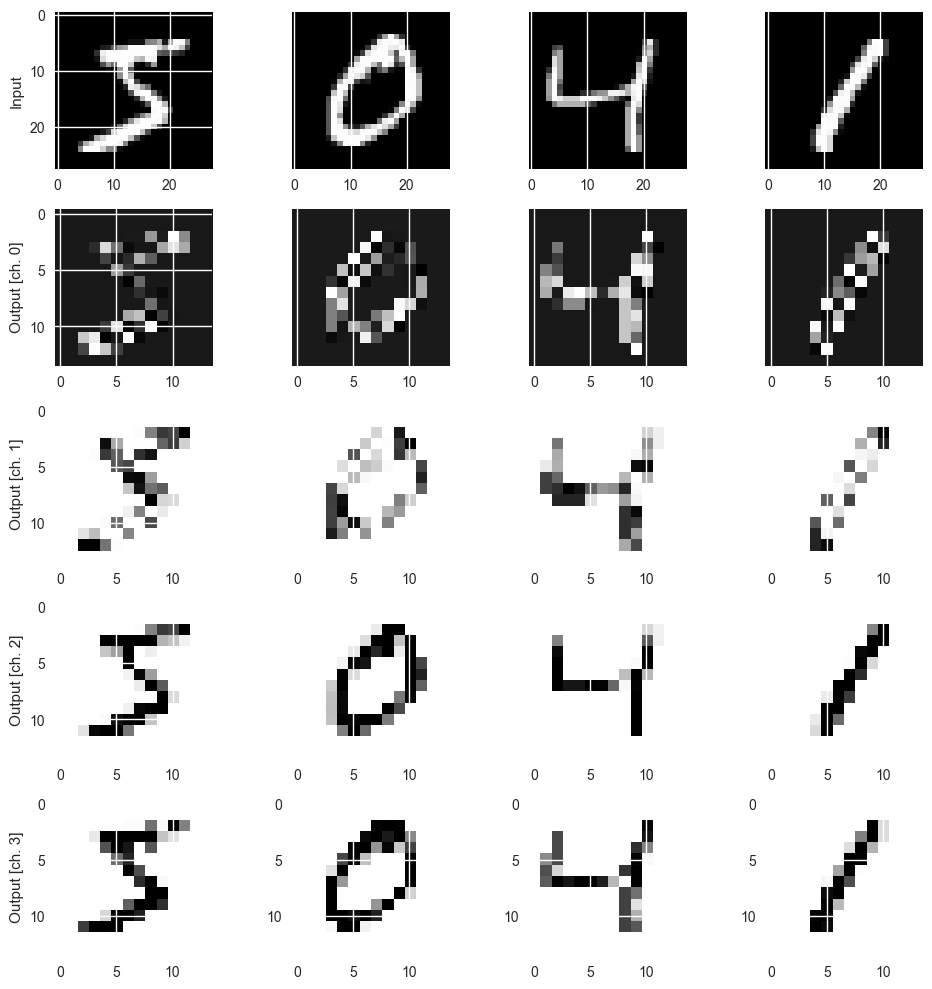

In [60]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [61]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [62]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/500


2022-10-12 16:09:10.514337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 1s - loss: 2.6414 - accuracy: 0.0800 - val_loss: 2.1522 - val_accuracy: 0.2000 - 520ms/epoch - 21ms/step
Epoch 2/500


2022-10-12 16:09:10.761611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 0s - loss: 1.7377 - accuracy: 0.4800 - val_loss: 1.7801 - val_accuracy: 0.4000 - 168ms/epoch - 7ms/step
Epoch 3/500
25/25 - 0s - loss: 1.2595 - accuracy: 0.6500 - val_loss: 1.5636 - val_accuracy: 0.5200 - 166ms/epoch - 7ms/step
Epoch 4/500
25/25 - 0s - loss: 0.9059 - accuracy: 0.8000 - val_loss: 1.2712 - val_accuracy: 0.5800 - 174ms/epoch - 7ms/step
Epoch 5/500
25/25 - 0s - loss: 0.7139 - accuracy: 0.8800 - val_loss: 1.2592 - val_accuracy: 0.6000 - 149ms/epoch - 6ms/step
Epoch 6/500
25/25 - 0s - loss: 0.5770 - accuracy: 0.9200 - val_loss: 1.2745 - val_accuracy: 0.6200 - 152ms/epoch - 6ms/step
Epoch 7/500
25/25 - 0s - loss: 0.4760 - accuracy: 0.9300 - val_loss: 1.0729 - val_accuracy: 0.6400 - 146ms/epoch - 6ms/step
Epoch 8/500
25/25 - 0s - loss: 0.3749 - accuracy: 0.9700 - val_loss: 1.0677 - val_accuracy: 0.7000 - 141ms/epoch - 6ms/step
Epoch 9/500
25/25 - 0s - loss: 0.3061 - accuracy: 0.9800 - val_loss: 0.9920 - val_accuracy: 0.6600 - 147ms/epoch - 6ms/step
Epoch 10/500
25/25 -

In [63]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/500


2022-10-12 16:10:24.292638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 0s - loss: 2.1036 - accuracy: 0.3000 - val_loss: 2.0080 - val_accuracy: 0.3600 - 464ms/epoch - 19ms/step
Epoch 2/500


2022-10-12 16:10:24.512084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


25/25 - 0s - loss: 1.5487 - accuracy: 0.7100 - val_loss: 1.6946 - val_accuracy: 0.5600 - 150ms/epoch - 6ms/step
Epoch 3/500
25/25 - 0s - loss: 1.1774 - accuracy: 0.8500 - val_loss: 1.4899 - val_accuracy: 0.6400 - 145ms/epoch - 6ms/step
Epoch 4/500
25/25 - 0s - loss: 0.9465 - accuracy: 0.8900 - val_loss: 1.3436 - val_accuracy: 0.7400 - 143ms/epoch - 6ms/step
Epoch 5/500
25/25 - 0s - loss: 0.7644 - accuracy: 0.9400 - val_loss: 1.2219 - val_accuracy: 0.7200 - 157ms/epoch - 6ms/step
Epoch 6/500
25/25 - 0s - loss: 0.6411 - accuracy: 0.9600 - val_loss: 1.1388 - val_accuracy: 0.7400 - 197ms/epoch - 8ms/step
Epoch 7/500
25/25 - 0s - loss: 0.5406 - accuracy: 0.9600 - val_loss: 1.0856 - val_accuracy: 0.7400 - 198ms/epoch - 8ms/step
Epoch 8/500
25/25 - 0s - loss: 0.4592 - accuracy: 0.9600 - val_loss: 1.0181 - val_accuracy: 0.7600 - 169ms/epoch - 7ms/step
Epoch 9/500
25/25 - 0s - loss: 0.3976 - accuracy: 0.9700 - val_loss: 0.9723 - val_accuracy: 0.7400 - 186ms/epoch - 7ms/step
Epoch 10/500
25/25 -

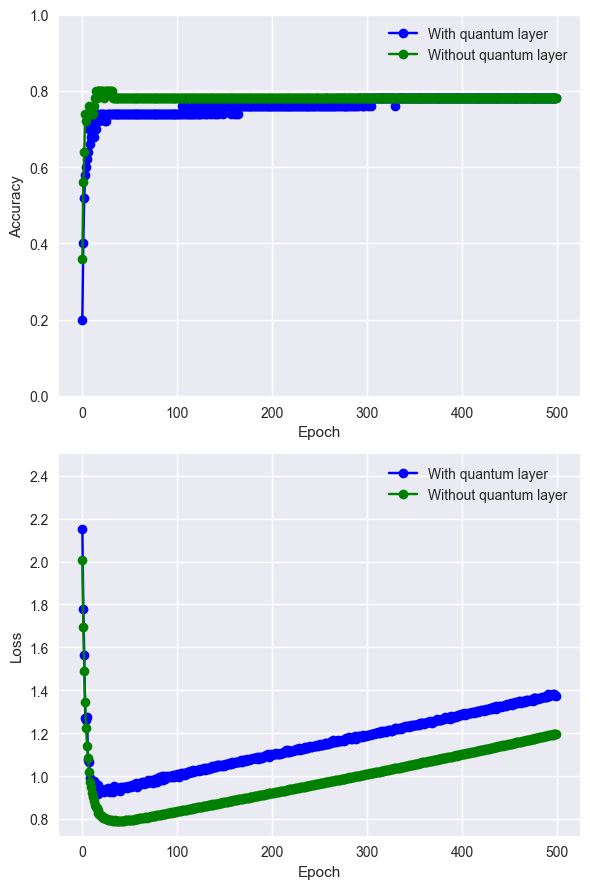

In [64]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()